<h1> Climate Data Visualization: Annual Atmospheric Profiles</h1>
<br>

Comprehensive visualization tool for atmospheric climatology data. This notebook processes and plots annual cycles of meteorological variables as pressure-time cross-sections, providing insights into seasonal variations of atmospheric conditions. Each variable is plotted with appropriate color schemes and optional wind barb overlays, enabling detailed analysis of atmospheric structure and seasonal patterns.
<br><br>

In [1]:
# Modify the parameters in this cell according to your requirements

# ID of selected station
ID = 'COM00080222'

# Period of climatology
clim_start_year = 1991
clim_end_year = 2020
clim_hour = 12  # UTC hour of sonde release

# Path of the repository folder
path_repo = '/home/david/radiosonde_climatology_analysis/'

<br><br><br>
<br><br><br>

# 0. Preamble (functions and libs)

In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import cmocean.cm as cmo
from datetime import datetime, timedelta


mandatory_levels = [1000, 925, 850, 700, 500, 400, 300, 250, 200, 150, 100]

months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

variables_info = {
    'geopotential_height': {
        'long_name': 'Geopotential Height',
        'units': 'm'
    },
    'temperature': {
        'long_name': 'Air Temperature',
        'units': '°C'
    },
    'relative_humidity': {
        'long_name': 'Relative Humidity',
        'units': '%'
    },
    'u_wind': {
        'long_name': 'U-Component of Wind',
        'units': 'm/s'
    },
    'v_wind': {
        'long_name': 'V-Component of Wind',
        'units': 'm/s'
    },
    'dewpoint_temperature': {
        'long_name': 'Dewpoint Temperature',
        'units': '°C'
    },
    'vapor_pressure': {
        'long_name': 'Vapor Pressure',
        'units': 'hPa'
    },
    'specific_humidity': {
        'long_name': 'Specific Humidity',
        'units': 'g/kg'
    },
    'equivalent_potential_temperature': {
        'long_name': 'Equivalent Potential Temperature',
        'units': 'K'
    },
    'potential_temperature': {
        'long_name': 'Potential Temperature',
        'units': 'K'
    },
    'wind_speed': {
        'long_name': 'Wind Speed',
        'units': 'm/s'
    },
    'air_density': {
        'long_name': 'Air Density',
        'units': 'kg/m³'
    },
    'wind_power_density': {
        'long_name': 'Wind Power Density',
        'units': 'W/m²'
    }
}

###########
def info_station(ID):
    ### Open metadata file
    
    df_DataFormat = pd.read_csv(f'{docs_folder}/format_stations_metadata.csv')
    colspecs = []
    selected_variables = df_DataFormat['col_name'].to_list()
    for i_var in df_DataFormat.index:
        var_i = df_DataFormat.loc[i_var, 'col_name']
        if not(var_i in selected_variables): continue
        idx_ini_i = df_DataFormat.loc[i_var, 'start_icol']
        idx_end_i = df_DataFormat.loc[i_var, 'end_icol']
        colspecs += [(idx_ini_i, idx_end_i)]
    
    metadatafile = f'{docs_folder}/igra2-station-list.txt'
    with open(metadatafile) as file:
        df_stations = pd.read_fwf(metadatafile, colspecs=colspecs, header=None, names=selected_variables)
    
    index_station = df_stations.loc[df_stations['id']==ID].index[0]
    
    name_estation = df_stations.loc[index_station,'name']

    coord = f'{df_stations.loc[index_station,'lat']:.2f}, {df_stations.loc[index_station,'lon']:.2f}'
    
    return f'{name_estation}   |   Lat, Lon: ({coord})   |   Period: {clim_start_year} - {clim_end_year}'

###########
def plot_annual_cycle(ID, variable, cmap, barbs, limits, zminmax=None):
    """
    Plot the annual climatological cycle of a meteorological variable.
    
    Parameters:
    -----------
    ID : str
        Station or location identifier
    variable : str
        Name of the meteorological variable to plot
    """
    
    # Read the climatological data
    df_var = pd.read_csv(f'{climatologies_folder}/{variable}.csv')
    df_var.columns = [int(col) if col.isdigit() else col for col in df_var.columns]
    
    # Find first valid row with data and subset dataframe
    first_valid_index = df_var[~df_var[list(range(1, 366))].isna().all(axis=1)].index[0]
    df_var = df_var.loc[first_valid_index:]
    
    # Set plot titles and labels
    title = f'Climatological Mean Profile of {variables_info[variable]['long_name']}'
    
    
    # Prepare data for plotting
    x = np.arange(1, 366, 1)  # Day of year
    y = df_var['pressure'].values  # Pressure levels
    z = df_var[range(1, 366, 1)].values  # Variable values

    if limits == 'symmetrical':
        z_amax = np.nanmax(np.abs(z), axis=None)
        y = np.concatenate(([10,20], y))
        z = np.vstack((np.full((1, z.shape[1]),np.nan), z))
        z = np.vstack((np.array([-z_amax if i % 2 == 0 else z_amax for i in range(z.shape[1])]).reshape(1, -1), z))
    if limits == 'definied':
        y = np.concatenate(([10,20], y))
        z = np.vstack((np.full((1, z.shape[1]),np.nan), z))
        z = np.vstack((np.array([zminmax[0] if i % 2 == 0 else zminmax[1] for i in range(z.shape[1])]).reshape(1, -1), z))
        z[z<zminmax[0]] = zminmax[0]
        z[z>zminmax[1]] = zminmax[1]
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(20, 8))
    
    # Plot the contour data
    heatmap = ax.contourf(x, y, z, 15, cmap=cmap, zorder=1)
    ax.contour(heatmap, colors='k', linestyles='solid', alpha=0.2, zorder=2)

    if barbs:
        # Load wind components data
        df_u = pd.read_csv(f'{climatologies_folder}/u_wind.csv')
        df_u.columns = [int(col) if col.isdigit() else col for col in df_u.columns]
        df_u = df_u.loc[df_u['pressure'].isin(mandatory_levels)]
        
        df_v = pd.read_csv(f'{climatologies_folder}/v_wind.csv')
        df_v.columns = [int(col) if col.isdigit() else col for col in df_v.columns]
        df_v = df_v.loc[df_v['pressure'].isin(mandatory_levels)]  # Fix: use df_v['pressure'] instead of df_u['pressure']
        
        # Add wind barbs for each month (15th day of each month)
        for month in range(1, 13):
            date = datetime(2022, month, 15)
            day_of_year = date.timetuple().tm_yday
            
            # Add wind barbs with pressure on vertical axis
            # Convert from m/s to knots (multiply by 1.94384)
            barbs = ax.barbs(
                np.full_like(df_v[day_of_year], day_of_year),  # x-position (day of year)
                df_v['pressure'],  # y-position (pressure levels)
                df_u[day_of_year] * 1.94384,  # u-component in knots
                df_v[day_of_year] * 1.94384,  # v-component in knots
                length=6, 
                pivot='middle', 
                zorder=5
        )

    # Format the plot axes
    ax.invert_yaxis()
    ax.set_yscale('log')
    
    # Configure x-axis (months)
    xticks = []
    xticklabels = []
    for day_of_year in range(1, 366, 1):
        date = datetime(2022, 1, 1) + timedelta(days=day_of_year - 1)  # Non-leap year
        if date.day == 1:  # First day of each month
            xticks.append(day_of_year)
            xticklabels.append(months[date.month - 1])
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    
    # Configure y-axis (pressure levels)
    min_pressure = int(df_var.loc[first_valid_index, 'pressure'])
    pressure_levels = [level for level in mandatory_levels if level <= min_pressure]
    
    # Adjust pressure levels if too close to minimum
    if abs(pressure_levels[0] - min_pressure) < 30:
        pressure_levels = pressure_levels[1:]
    pressure_levels = [min_pressure] + pressure_levels
    
    ax.set_ylabel('Pressure [hPa]', fontsize=12)
    ax.set_yticks(pressure_levels)
    ax.set_yticklabels([str(tick) for tick in pressure_levels])
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=False))
    ax.minorticks_off()
    ax.set_ylim([min_pressure, 100])
    
    # Align x-axis labels
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')
    
    # Add grid and title
    ax.grid(True, color='white', alpha=0.1)
    ax.text(0.5, 1.07, title, transform=ax.transAxes, ha='center', va='bottom', fontsize=16)
    ax.text(0.5, 1.02, info_station(ID), transform=ax.transAxes, ha='center', va='bottom', fontsize=12)
    
    # Add colorbar
    colorbar_label = f'{variables_info[variable]['long_name'].capitalize()} [{variables_info[variable]['units']}] '
    colorbar = fig.colorbar(heatmap, pad=0.03)
    colorbar.set_label(colorbar_label, fontsize=12, labelpad=10)
    # format ticks label of colorbar
    formatter = FuncFormatter(lambda val, _: f'{val:g}'.ljust(5))
    colorbar.ax.yaxis.set_major_formatter(formatter)
    for label in colorbar.ax.get_yticklabels():
        label.set_fontname('monospace')
        label.set_fontsize(12)

    # Add labels for U and V winds
    if variable == 'u_wind':
        colorbar.ax.text(-0.35, 0.85, 'Eastward direction', va='center', ha='center', rotation=90, transform=colorbar.ax.transAxes, fontsize=12)
        colorbar.ax.text(-0.35, 0.15, 'Westward direction', va='center', ha='center', rotation=90, transform=colorbar.ax.transAxes, fontsize=12)
    if variable == 'v_wind':
        colorbar.ax.text(-0.35, 0.85, 'Northward direction', va='center', ha='center', rotation=90, transform=colorbar.ax.transAxes, fontsize=12)
        colorbar.ax.text(-0.35, 0.15, 'Southward direction', va='center', ha='center', rotation=90, transform=colorbar.ax.transAxes, fontsize=12)
    
    # Save and display the plot
    plt.savefig(f'{plots_folder}/{ID}_{variable}.png', dpi=300, bbox_inches='tight')
    plt.show()

<br><br><br>
<br><br><br>

# 1. Climatologies plots

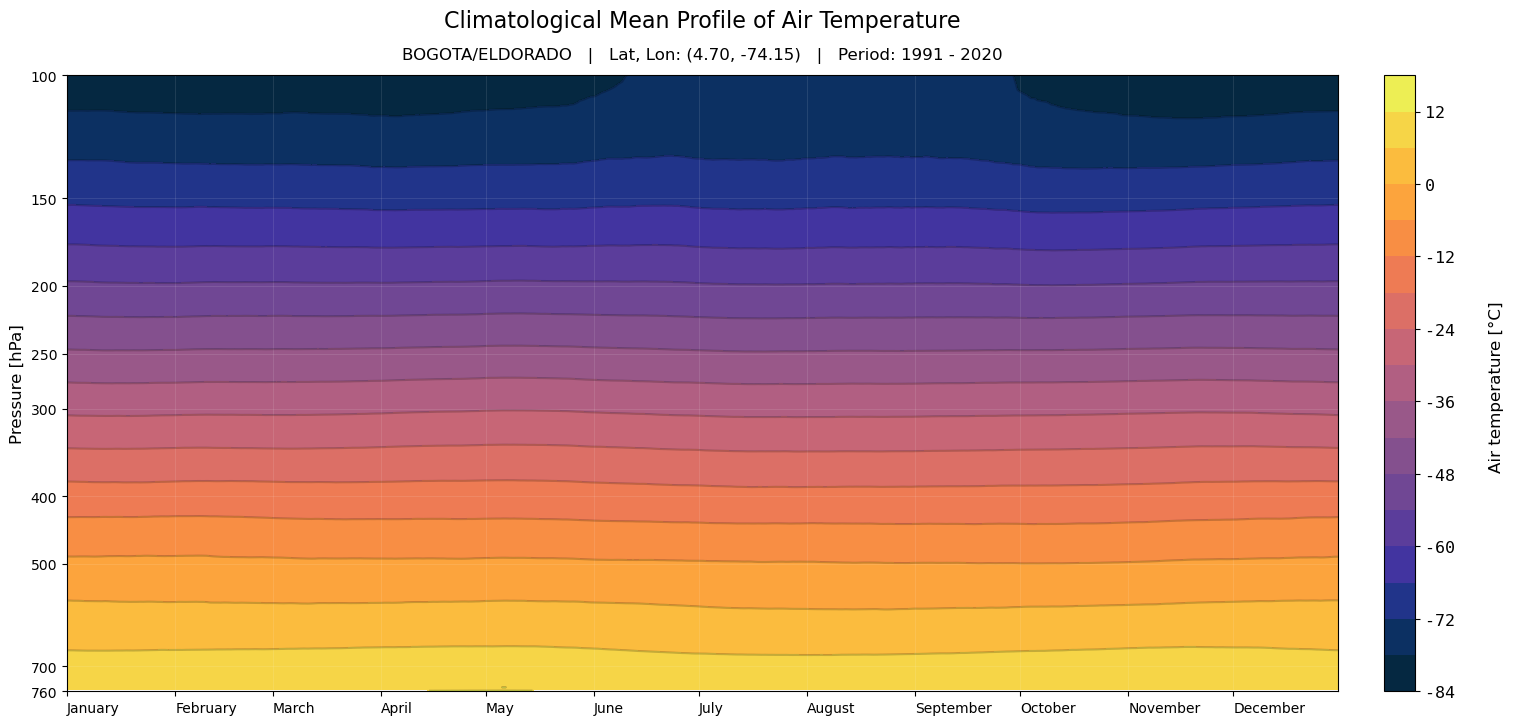

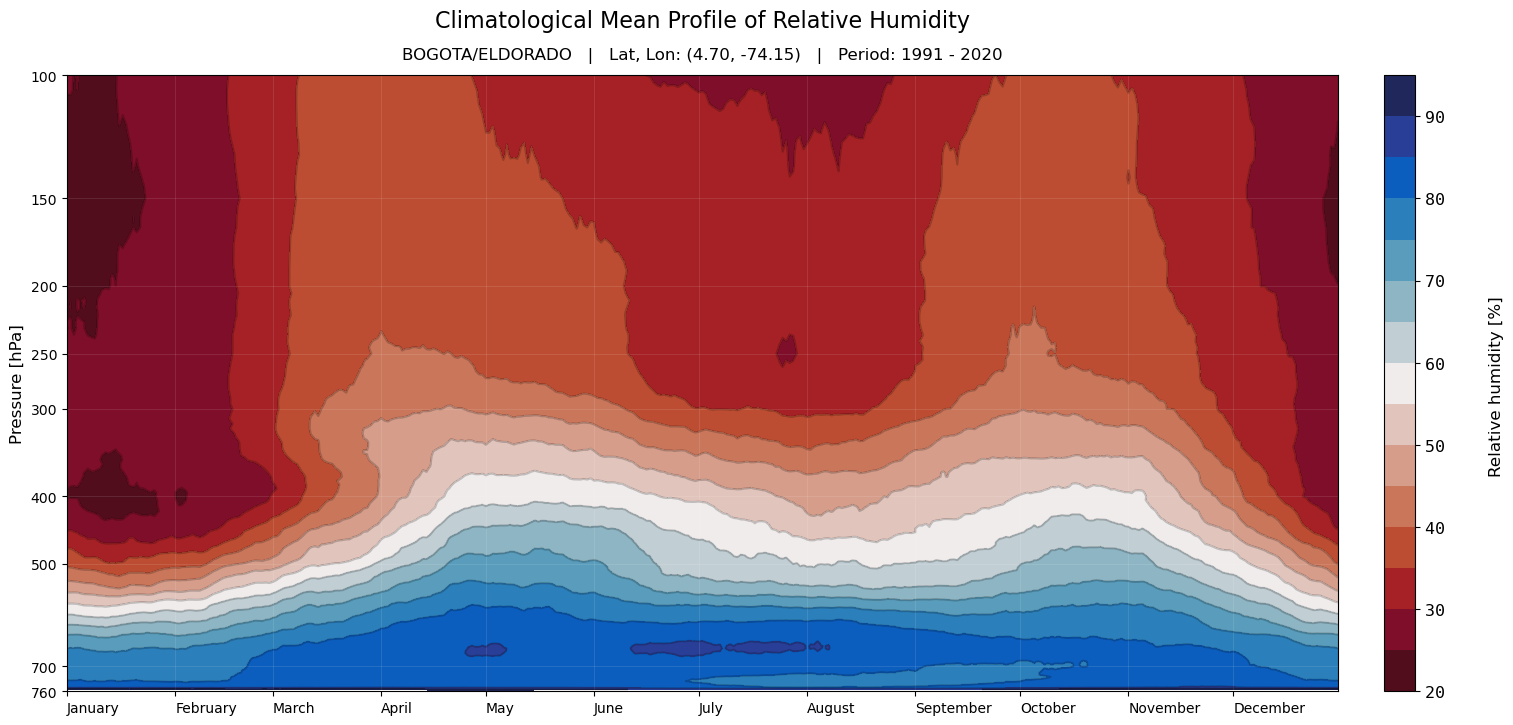

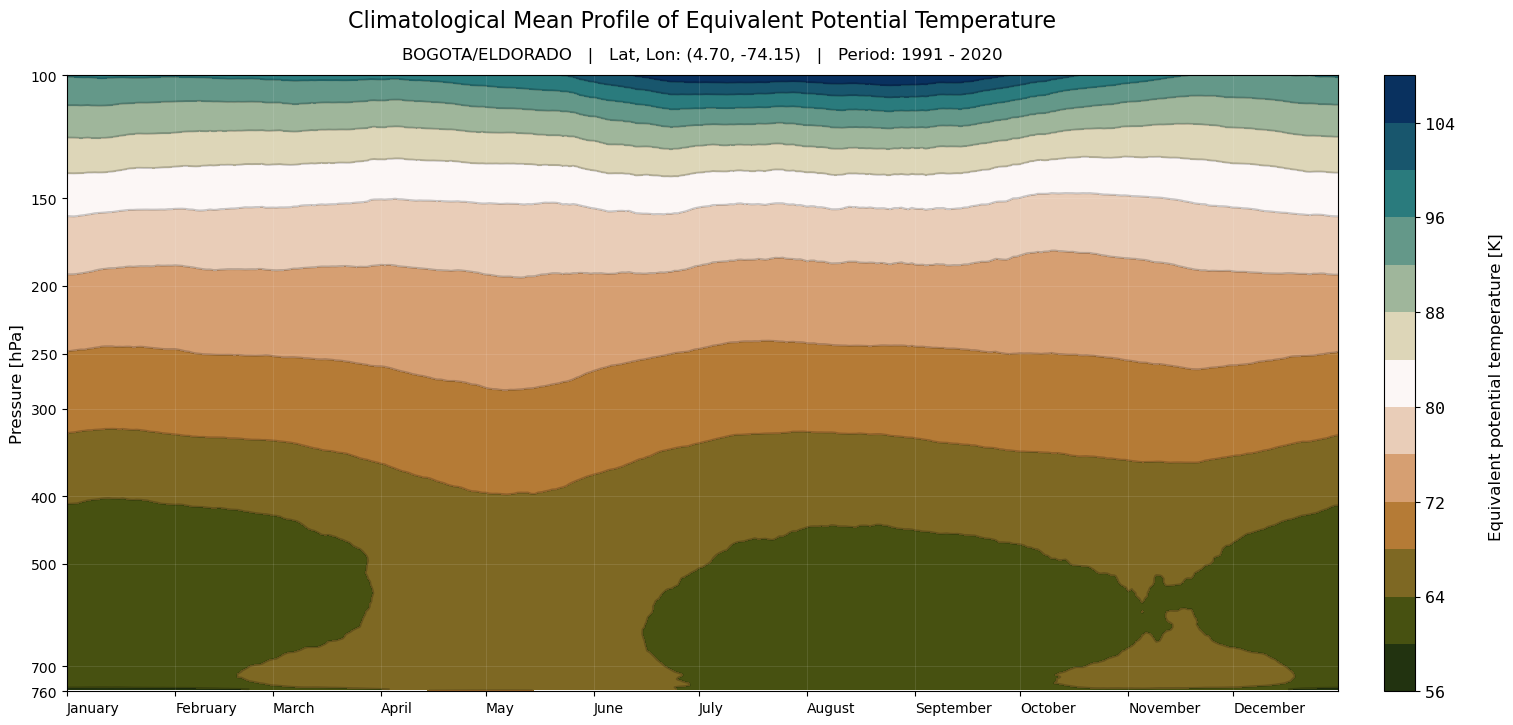

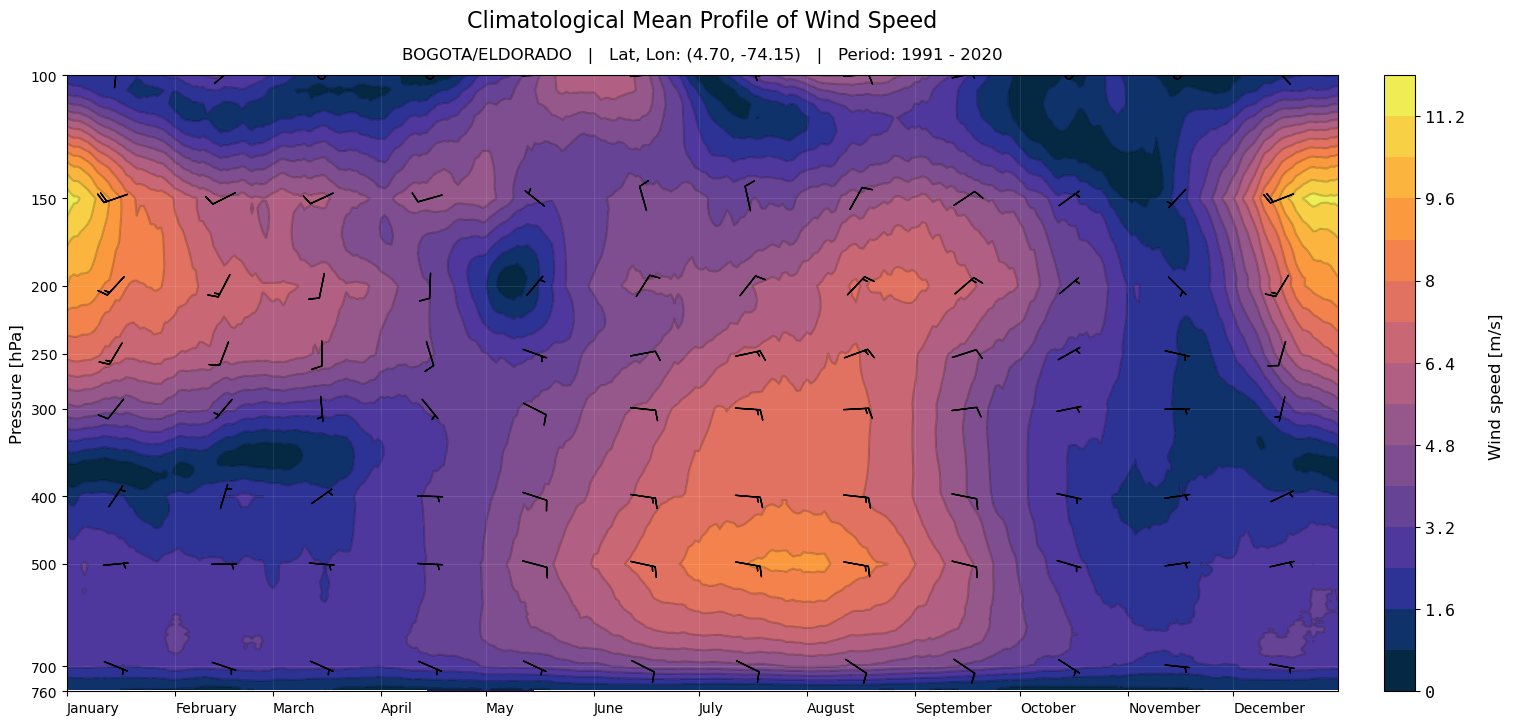

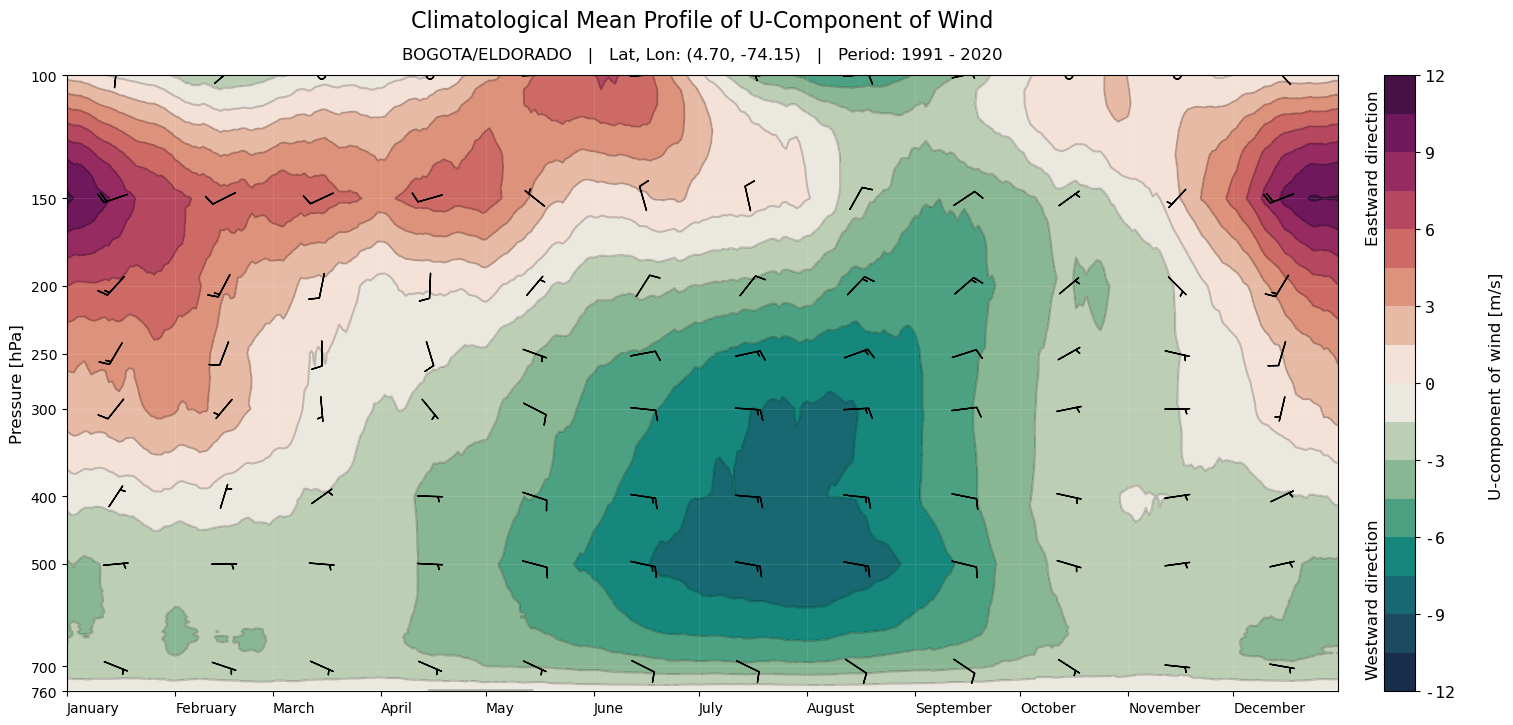

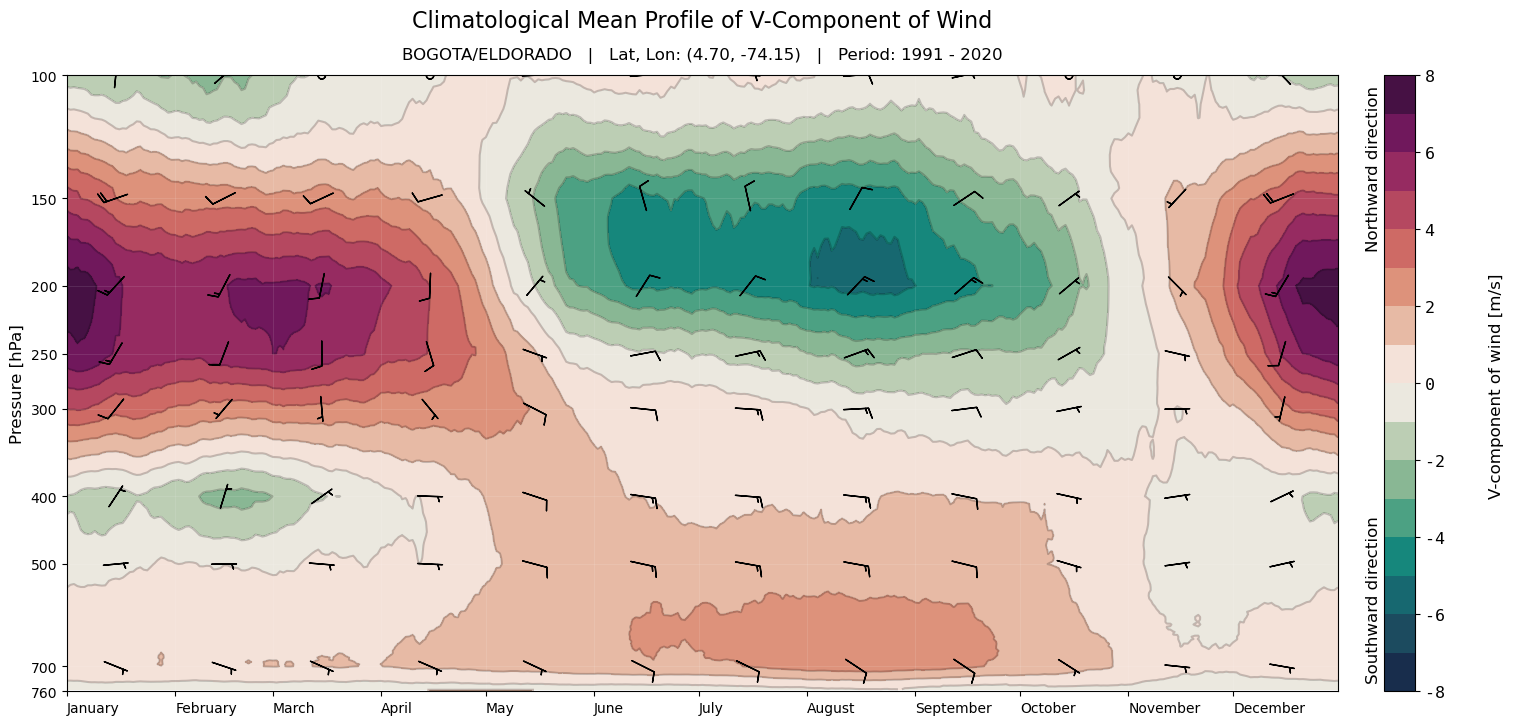

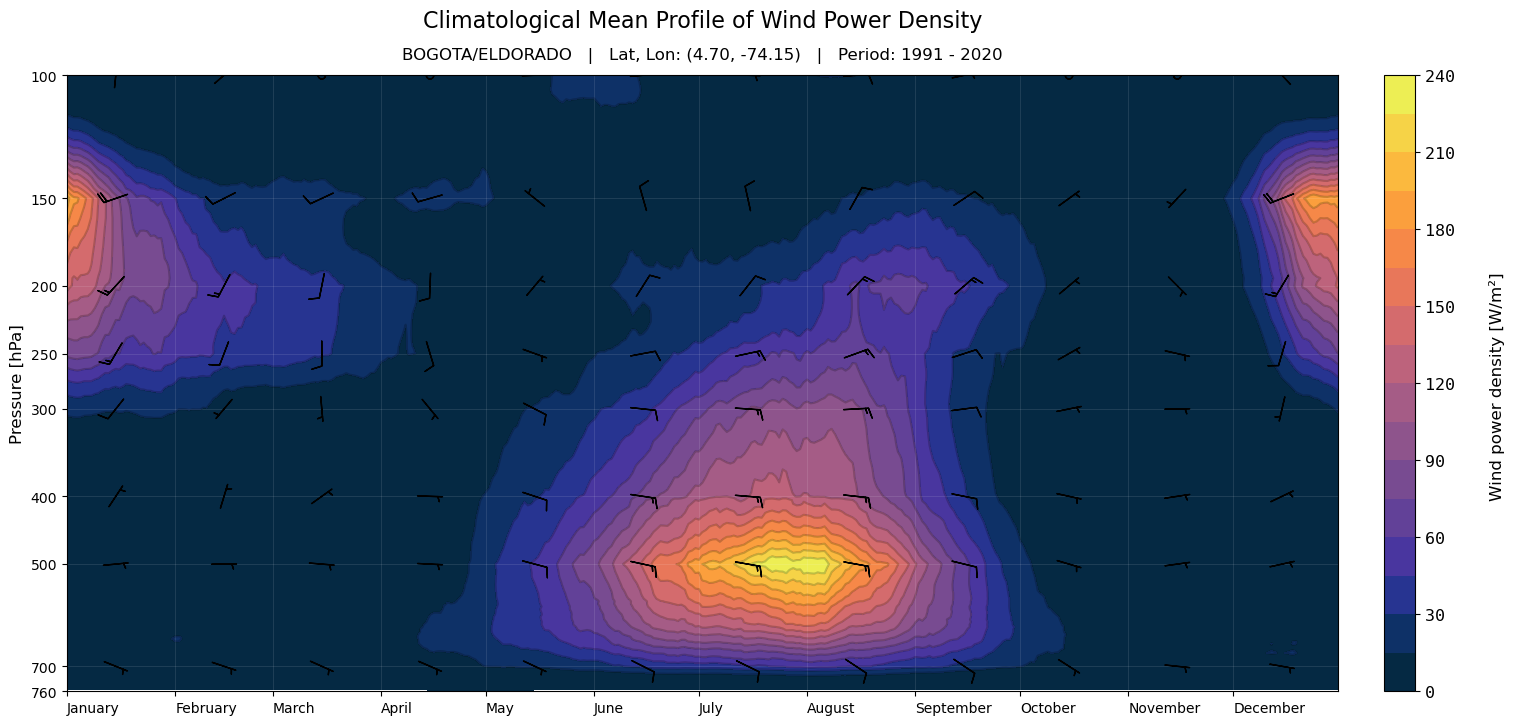

In [3]:
############
### folders' paths

docs_folder = f'{path_repo}/docs/'
station_folder = f'{path_repo}/data/{ID}/'
climatologies_folder = f'{station_folder}/climatology/'
plots_folder = f'{path_repo}/figures/{ID}/'


############
### Creating the station's folders

os.makedirs(plots_folder, exist_ok = True)



############
### Plot settings for meteorological variables

var_plot_settings = {
    
    'temperature':                      {'cmap': cmo.thermal,   'barbs': False, 'limits': 'undefined',   'zminmax': None},
    'relative_humidity':                {'cmap': cmo.balance_r, 'barbs': False, 'limits': 'defined',     'zminmax': [0, 100]},
    'equivalent_potential_temperature': {'cmap': cmo.tarn,      'barbs': False, 'limits': 'undefined',   'zminmax': None},
    'wind_speed':                       {'cmap': cmo.thermal,   'barbs': True,  'limits': 'undefined',   'zminmax': None},
    'u_wind':                           {'cmap': cmo.curl,      'barbs': True,  'limits': 'symmetrical', 'zminmax': None},
    'v_wind':                           {'cmap': cmo.curl,      'barbs': True,  'limits': 'symmetrical', 'zminmax': None},    
    'wind_power_density':               {'cmap': cmo.thermal,   'barbs': True,  'limits': 'undefined',   'zminmax': None},
    
    # Uncommented variables - add these if needed for plotting
    # 'geopotential_height':              {'cmap': cmo.thermal,   'barbs': False, 'limits': 'undefined',   'zminmax': None},
    # 'dewpoint_temperature':             {'cmap': cmo.thermal,   'barbs': False, 'limits': 'undefined',   'zminmax': None},
    # 'vapor_pressure':                   {'cmap': cmo.thermal,   'barbs': False, 'limits': 'undefined',   'zminmax': None},
    # 'specific_humidity':                {'cmap': cmo.thermal,   'barbs': False, 'limits': 'undefined',   'zminmax': None},
    # 'potential_temperature':            {'cmap': cmo.thermal,   'barbs': False, 'limits': 'undefined',   'zminmax': None},
    # 'air_density':                      {'cmap': cmo.thermal,   'barbs': False, 'limits': 'undefined',   'zminmax': None},
}



############
### Plot annual cycles for all configured variables


for variable in var_plot_settings.keys():
    plot_annual_cycle(ID=ID,
                      variable=variable,
                      cmap=var_plot_settings[variable]['cmap'],
                      barbs=var_plot_settings[variable]['barbs'],
                      limits=var_plot_settings[variable]['limits'],
                      zminmax=var_plot_settings[variable]['zminmax'])
    print('\n' * 2)  # Add spacing between plots